# Exploratory Data Analysis

Random preliminary analysis on the NBA boxscore (df_box) and play by play (df_pbp) datasets

### Import and clean the Data

In [110]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [43]:
#import the boxscores dataset
df_box = pd.read_csv('data/df_box_scores_2000_2018_clean.csv').drop(columns=['Unnamed: 0'])
#import the dataset with links, dates, and whether the game was in the playoffs or regular season
df_playoffs = pd.read_csv('data/df_playoff_dates_1959_2019_clean.csv').rename(columns={'playoff_dates':'playoff_date'})

In [44]:
df_box.shape
df_playoffs.shape

(531441, 42)

(61, 3)

In [45]:
#change the playoff date to datetime format
df_playoffs['playoff_date'] = pd.to_datetime(df_playoffs['playoff_date'])

In [46]:
#get rid of the full URL in the 'link' column 
df_box['link'] = df_box['link'].apply(lambda x: x.split('boxscores/')[1].split('.html')[0])

In [47]:
#fix some errors in the data
df_box.loc[313944:313947, 'team'] = 'Dallas Mavericks'
df_box.loc[206215:206218, 'team'] = 'Philadelphia 76ers'

In [48]:
#create array to store seasons to iterate through in the for loop
seasons = df_box['season'].unique()

#iterate through each season, add in column describing if the season is in 
df_box_by_season = pd.DataFrame()
for season in seasons:
    df_season = df_box[df_box['season']==season]
    df_season = df_season.merge(df_playoffs[['season','playoff_date']], how='left', on='season')
    df_season['date'] = pd.to_datetime(df_season['date'])
    #determine if the date in the game is earlier than the corresponding season's playoff date
    df_season['time_of_year'] = np.where(df_season['playoff_date'] >= df_season['date'], 'regular_season', 'playoffs')
    df_box_by_season = df_box_by_season.append(df_season)

In [49]:
#get rid of the playoff date column and 
df_box = df_box_by_season.drop(columns=['playoff_date'])

In [50]:
df_box.head()

,player,team,team_key,mp,fg,fga,fg%,3p,3pa,3p%,...,TOV%,USG%,ORtg,DRtg,key,game,date,season,link,time_of_year
0,harprma01,Utah Jazz,away,30:00,6.0,12.0,0.500,0.0,0.0,NaN,...,17.0,26.9,109.0,90.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
1,malonka01,Utah Jazz,away,29:00,6.0,7.0,0.857,0.0,0.0,NaN,...,17.2,18.3,146.0,71.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
2,stockjo01,Utah Jazz,away,21:00,1.0,3.0,0.333,0.0,0.0,NaN,...,13.3,16.4,142.0,77.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
3,ostergr01,Utah Jazz,away,19:00,1.0,3.0,0.333,0.0,0.0,NaN,...,0.0,7.2,117.0,88.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season
4,cheanca01,Utah Jazz,away,17:00,2.0,5.0,0.400,0.0,0.0,NaN,...,28.6,18.8,70.0,97.0,2003_4174,Utah Jazz at Memphis Grizzlies,2002-12-22,2003,200212220MEM,regular_season


# Begin Random EDA

### Do the number of fouls called change from the regular season to the playoffs?

In [51]:
#Get the total number of fouls per game, per season and put it to another dataset 
df_fouls = df_box.groupby(['link', 'time_of_year','season'])['pf'].sum().reset_index()

In [106]:
df_fouls.head()

,link,time_of_year,season,pf
0,199911020CHH,regular_season,2000,56.0
1,199911020DAL,regular_season,2000,48.0
2,199911020DEN,regular_season,2000,45.0
3,199911020HOU,regular_season,2000,49.0
4,199911020LAC,regular_season,2000,45.0


In [109]:
#get the average number of fouls per game in the regular season versus the playoffs for all seasons
df_pf_per_year = df_fouls.groupby(['time_of_year','season'])['pf'].mean().reset_index()
regular_pf = df_pf_per_year[df_pf_per_year['time_of_year']=='regular_season'].drop(columns=['time_of_year']).rename(columns={'pf':'pf_regular'})
playoff_pf = df_pf_per_year[df_pf_per_year['time_of_year']=='playoffs'].drop(columns=['time_of_year']).rename(columns={'pf':'pf_playoffs'})

df_pf_per_year = pd.merge(regular_pf, playoff_pf, how='left',on='season')
df_pf_per_year['pf_difference'] = df_pf_per_year['pf_regular'] - df_pf_per_year['pf_playoffs']
df_pf_per_year.head()

,season,pf_regular,pf_playoffs,pf_difference
0,2000,46.606035,48.464789,-1.858754
1,2001,44.692372,45.373134,-0.680762
2,2002,42.439229,47.850746,-5.411517
3,2003,43.522613,48.722892,-5.200279
4,2004,42.910310,46.487179,-3.576869


Text(0.5,0,'Season')

Text(0,0.5,'Average fouls per game')

Text(0.5,1,'Average Fouls Per Game per Season')

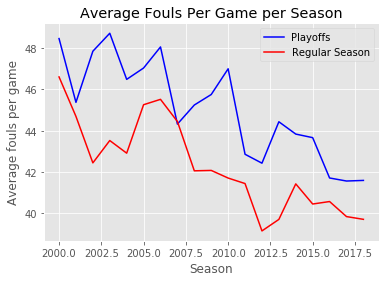

In [125]:
plt.style.use('ggplot')
plt.plot(df_pf_per_year['season'], df_pf_per_year['pf_playoffs'], color='blue', label='Playoffs')
plt.plot(df_pf_per_year['season'], df_pf_per_year['pf_regular'], color='red', label='Regular Season')
plt.xlabel('Season')
plt.ylabel('Average fouls per game')
plt.title('Average Fouls Per Game per Season')
plt.legend()
plt.show()